# Influx DB - Home Assistant

In [2]:
!pip install influxdb-client

#### Connect to Influx server

In [6]:
INFLUXDB_TOKEN="aTpzugDYTgNk_Q-9CXV2ACQahgS-x-ZigchoQ6F-8L82SZajSflmaJDs3-E-yCe-5Da08_ZpUiMPhuLmtd75qA==" # My token is different from your, retrieve from influx python interface
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

token = INFLUXDB_TOKEN
org = "homeassistant"
url = "http://localhost:8086"

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)


### Queries on homeassistant-aggregated (per il bene del vostro pc)

#### Load temperature values of my pht sensor in the last 30 days

Index(['result', 'table', '_start', '_stop', '_time', '_value', '_field',
       '_measurement', 'domain', 'entity_id', 'instance', 'source'],
      dtype='object')
0       21.189744
1       21.211538
2       21.239474
3       21.247222
4       21.244118
          ...    
2510    18.241667
2511    18.216667
2512    18.169697
2513    18.154286
2514    18.115385
Name: _value, Length: 2515, dtype: float64


<AxesSubplot:xlabel='_time'>

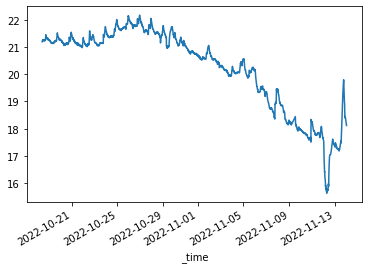

In [30]:
query="""
from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> filter(fn: (r) => r["_field"] == "value")
"""
df_temperature = client.query_api().query_data_frame(query, org="homeassistant")
# Examine the columns
print(df_temperature.columns)
# Print the value column
print(df_temperature["_value"])
# Display the values
df_temperature.set_index("_time")["_value"].plot()

#### 1) Exercise: Aggregate
Edit the query so that the data is averaged for each day. Do it with influx query not pandas

##### Solution

<AxesSubplot:>

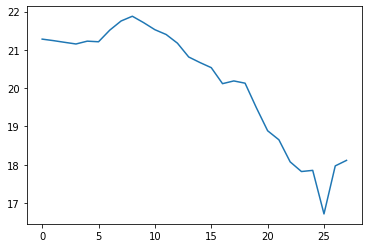

In [16]:
query="""
from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> filter(fn: (r) => r["_field"] == "value")
  |> aggregateWindow(every: 1d, fn: mean)
"""
df_temperature = client.query_api().query_data_frame(query, org="homeassistant")
# Display the values
df_temperature["_value"].plot()

#### 2) Exercise: Changes in data
Edit the query so that it looks for data value rate of change.
What kind of math function looks for a change in data??  

##### Solution

<AxesSubplot:xlabel='_time'>

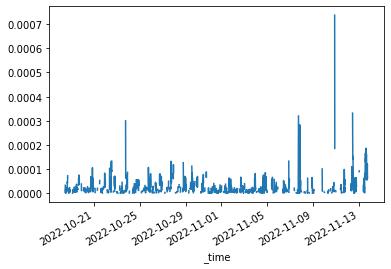

In [39]:
query="""
from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> filter(fn: (r) => r["_field"] == "value")
  |> derivative(unit: 1s, nonNegative: true, columns: ["_value"], timeColumn: "_time")
"""
df_temperature_changes = client.query_api().query_data_frame(query, org="homeassistant")
# Display the values
df_temperature_changes.set_index("_time")["_value"].plot()

#### 3) Exercise: Averaged changes
Average changes so that is clear In which days data is changed most

##### Solution

<AxesSubplot:xlabel='_time'>

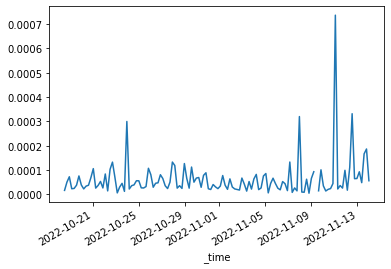

In [38]:
query="""
from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> filter(fn: (r) => r["_field"] == "value")
  |> derivative(unit: 1s, nonNegative: true, columns: ["_value"], timeColumn: "_time")
  |> aggregateWindow(every: 5h, fn: max)
"""
df_temperature_changes = client.query_api().query_data_frame(query, org="homeassistant")
# Display the values
df_temperature_changes.set_index("_time")["_value"].plot()

#### 4) HARD Exercise: Correlation
Compute the correlation between pht_temperature and openweather temperature
Correlation works on two columns -> need to create the two columns
Some helps:
1. Must have uniform time-ranges (10 minutes) -> time truncation
2. Decide how to fill holes
3. Crate the columns -> pivoting
4. Compute correlation -> Pearson correlation

##### Solution

In [37]:
query="""
import "interpolate"
from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature" or r["entity_id"] == "openweathermap_temperature")
//|> truncateTimeColumn(unit: 10m)
  |> interpolate.linear(every: 10m)  
  |> fill(column: "_value", usePrevious: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field", "entity_id"], valueColumn: "_value")
  |> covariance(columns: ["value_basement_bed_pht_temperature", "value_openweathermap_temperature"], pearsonr: true, valueDst: "_value")   
"""
df_result = client.query_api().query_data_frame(query, org="homeassistant")
covariance = df_result["_value"][0]
print(f"Covariance is: {covariance}")

Correlation is: 0.6172505156856504


#### 5) Exercise: Compute histogram over temperature bins
Group temperatures with upper bounds bins: [15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0]

For each bin count how many times the temperature goes below that value

Influx support the operation by default

##### Solution

In [43]:
query="""
from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> histogram(column: "_value", upperBoundColumn: "le", countColumn: "_value", bins: [15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0], normalize: false)
"""
df_result = client.query_api().query_data_frame(query, org="homeassistant")
bins = df_result[["le", "_value"]]
print(bins)

      le  _value
0   15.0     0.0
1   16.0    28.0
2   17.0    48.0
3   18.0   338.0
4   19.0   578.0
5   20.0   777.0
6   21.0  1314.0
7   22.0  2484.0
8   23.0  2511.0
9   24.0  2511.0
10  25.0  2511.0


#### 6) Exercise: perform union of queries
Define two queries
- query on basement light truncated every 10 minutes
- query on temperature truncated every 10 minutes
- union

##### Solution

In [48]:
query="""
light = from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "light")
  |> filter(fn: (r) => r["entity_id"] == "basement")
  |> filter(fn: (r) => r["_field"] == "value")
  |> truncateTimeColumn(unit: 10m)
  
temp = from(bucket: "homeassistant-aggregated")
  |> range(start: -30d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> filter(fn: (r) => r["_field"] == "value")
  |> truncateTimeColumn(unit: 10m)

// from join(tables: {key1: light, key2: temp}, on: ["_time", "_field"], method: "inner")
from union(tables: [light, temp])
"""
df_result = client.query_api().query_data_frame(query, org="homeassistant")
print(df_result.head(2))

    result  table _field _measurement                           _start  \
0  _result      0  value        state 2022-10-18 13:14:24.869065+00:00   
1  _result      0  value        state 2022-10-18 13:14:24.869065+00:00   

                             _stop                     _time  _value domain  \
0 2022-11-17 13:14:24.869065+00:00 2022-10-18 16:50:00+00:00     1.0  light   
1 2022-11-17 13:14:24.869065+00:00 2022-10-18 17:50:00+00:00     0.0  light   

  entity_id    instance source  
0  basement  production     HA  
1  basement  production     HA  


#### 7) HARD Exercise: Covariance between bedroom light and spikes in temperature in the room
Help:
1. Define the two queries
2. Truncate each query every 2h
3. Fill empty values using best technique
    - light -> what to do if there are holes? 
    - temperature -> we want spikes in the 2h range
4. ViewOnly: [View with union]
5. Merge with join
6. Perform covariance

##### Solution

In [49]:
query = """ 
light = from(bucket: "homeassistant-aggregated")
  |> range(start: -10d)
  |> filter(fn: (r) => r["domain"] == "light")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_ceil")
  |> filter(fn: (r) => r["_field"] == "value")
  |> truncateTimeColumn(unit: 2h)
  |> fill(column: "_value", usePrevious: true)
  
temp = from(bucket: "homeassistant-aggregated")
  |> range(start: -10d)
  |> filter(fn: (r) => r["domain"] == "sensor")
  |> filter(fn: (r) => r["entity_id"] == "basement_bed_pht_temperature")
  |> filter(fn: (r) => r["_field"] == "value")
  |> truncateTimeColumn(unit: 2h)
  |> derivative(unit: 2h, nonNegative: true, columns: ["_value"], timeColumn: "_time")

// Uncomment to view result on influx
// union(tables: [light, temp])

// Comment to view result on influx
from join(tables: {key1: light, key2: temp}, on: ["_time", "_field"], method: "inner")
  |> covariance(columns: ["_value_key1", "_value_key2"], pearsonr: true, valueDst: "_value") 

"""
df_result = client.query_api().query_data_frame(query, org="homeassistant")
covariance = df_result["_value"][0]
print(f"Covariance is: {covariance}")

Covariance is: -0.12893682362406608
